## Data Preparation

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics
import math

#for LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

2024-03-07 19:13:30.850750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# read data
data = pd.read_csv("Historical Product Demand.csv")
data

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [3]:
# rename the columns
data.rename(columns = {'Product_Code': 'ProductCode',
                       'Product_Category': 'ProductCategory', 
                       'Order_Demand': 'OrderDemand'}, inplace = True)
data.head()

,ProductCode,Warehouse,ProductCategory,Date,OrderDemand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [4]:
# check the null data
data.isnull().sum()

ProductCode            0
Warehouse              0
ProductCategory        0
Date               11239
OrderDemand            0
dtype: int64

In [5]:
# drop the missing values
data.dropna(inplace=True)

# check the null data again
data.isnull().sum()

ProductCode        0
Warehouse          0
ProductCategory    0
Date               0
OrderDemand        0
dtype: int64

In [6]:
# sort the data berdasarkan kolom tanggal
data.sort_values('Date', ignore_index=True, inplace=True)
data.head()

,ProductCode,Warehouse,ProductCategory,Date,OrderDemand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


In [7]:
# ada tanda () di kolom OrderDemand
data['OrderDemand'] = data['OrderDemand'].str.replace('(',"")
data['OrderDemand'] = data['OrderDemand'].str.replace(')',"")

# Mengubah tipe data menjadi integer
data['OrderDemand'] = data['OrderDemand'].astype('int64')

In [33]:
# creating Year, Month, Day field for further analysis

# Mengubah tipe data menjadi datetime
from datetime import datetime as dt

data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day

data['Year'] = data['Year'].astype(str)

## Exploratory Data Analysis and Data Visualization

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037336 entries, 0 to 1037335
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   ProductCode      1037336 non-null  object        
 1   Warehouse        1037336 non-null  object        
 2   ProductCategory  1037336 non-null  object        
 3   Date             1037336 non-null  datetime64[ns]
 4   OrderDemand      1037336 non-null  int64         
 5   Year             1037336 non-null  int32         
 6   Month            1037336 non-null  int32         
 7   Day              1037336 non-null  int32         
dtypes: datetime64[ns](1), int32(3), int64(1), object(3)
memory usage: 51.4+ MB


In [28]:
data["OrderDemand"].describe()

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: OrderDemand, dtype: float64

In [29]:
# information about categorical variables
data[["ProductCode", "Warehouse", "ProductCategory"]].describe()

,ProductCode,Warehouse,ProductCategory
count,1037336,1037336,1037336
unique,2160,4,33
top,Product_1359,Whse_J,Category_019
freq,16936,764447,470266


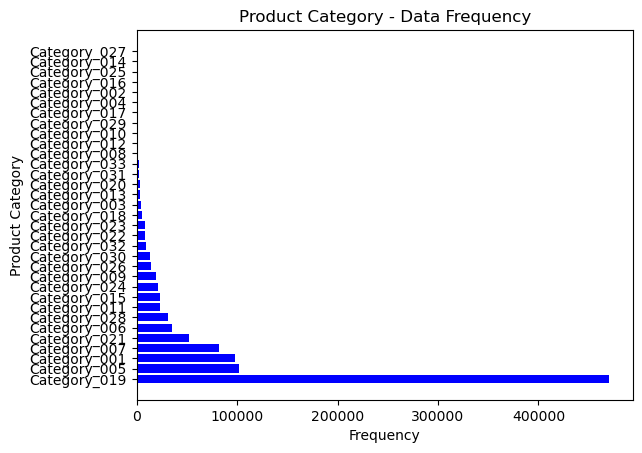

Number of ProductCategory 
ProductCategory
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: count, dtype: int64


In [14]:
# Jumlah data berdasarkan product category
plt.figure()
plt.barh(data["ProductCategory"].value_counts().index, data["ProductCategory"].value_counts(), color = "b")
plt.xlabel("Frequency")
plt.ylabel("Product Category")
plt.title("Product Category - Data Frequency")
plt.show()
print(f"Number of ProductCategory \n{data['ProductCategory'].value_counts()}")

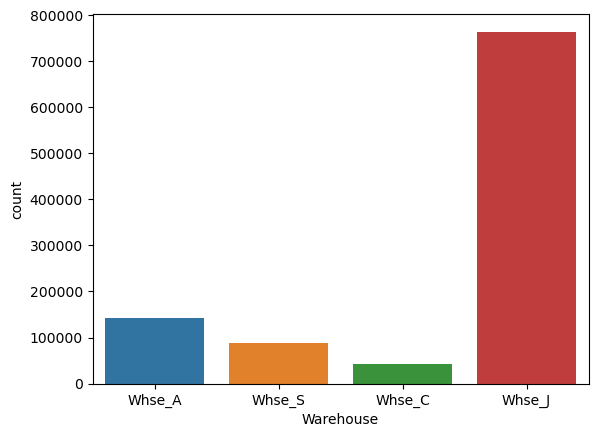

Number of samples according to Warehouse 
Warehouse
Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: count, dtype: int64


In [30]:
# Jumlah data berdasarkan Warehouse
sns.countplot(x="Warehouse", data=data)
plt.xticks(rotation = 0)
plt.show()
print(f"Number of samples according to Warehouse \n{data['Warehouse'].value_counts()}")

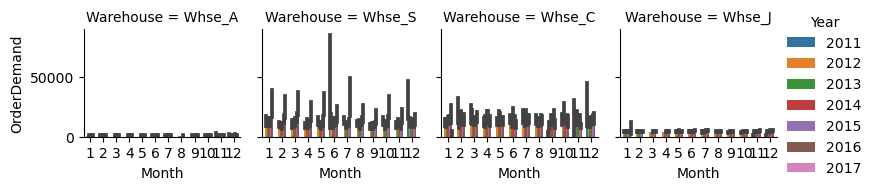

In [34]:
sns.catplot(x="Month", y="OrderDemand",  hue="Year", col="Warehouse",
            data=data, kind="bar", height=2)
plt.show()

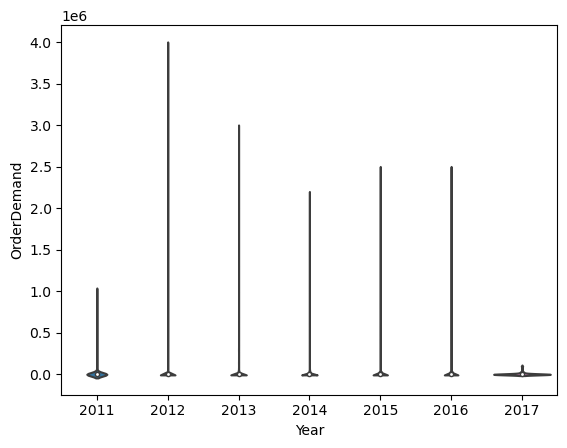

In [35]:
sns.violinplot(x="Year", y="OrderDemand", data=data)
plt.show()

#### Yearly Analysis

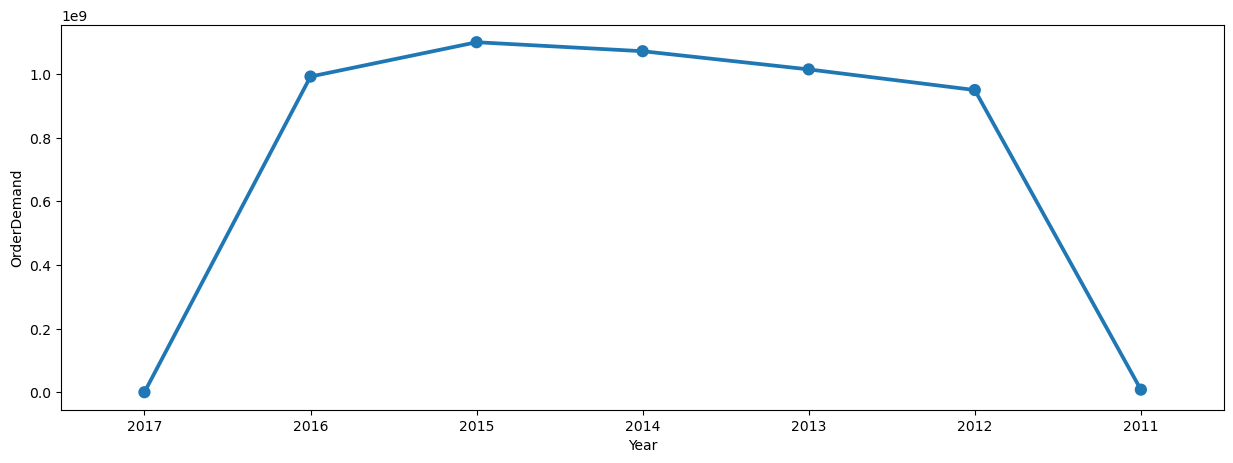

In [36]:
df = data[['OrderDemand', 'Year']].groupby(["Year"]).sum().reset_index().sort_values(by='Year', ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='OrderDemand', data=df)
plt.show()

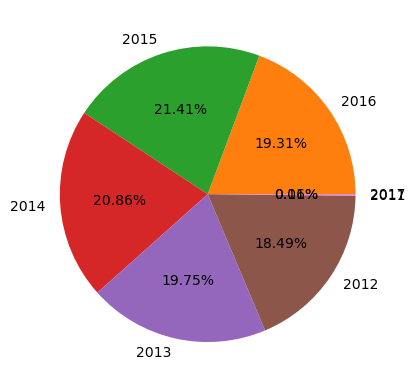

In [38]:
# plot pie chart persentase order demand
plt.pie(df['OrderDemand'], labels=df['Year'].unique(), autopct='%1.2f%%')
plt.show() 

#### Monthly Analysis

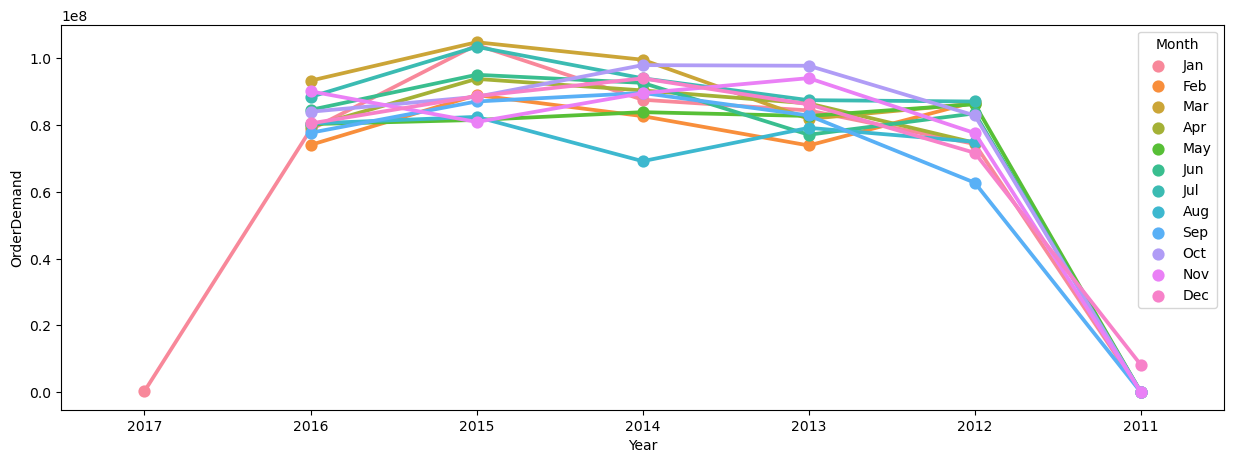

In [39]:
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May',
                                                       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[['OrderDemand',
                'Month', 'Year',]].groupby(["Year",
                                            "Month"]).sum().reset_index().sort_values(by=['Year',
                                                                                          'Month'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='OrderDemand', data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May',
                                                                          'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [40]:
# Monthly pivot table
df = (df.pivot(index='Year', columns='Month', values='OrderDemand'))
df = df.loc[:, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,2.0,NaN,NaN,NaN,108.0,92000.0,NaN,NaN,6728.0,7.0,86524.0,8178525.0
2012,74331037.0,86951780.0,86463212.0,74714053.0,86246051.0,83521679.0,87071567.0,75003241.0,62748329.0,82891675.0,77618687.0,71698680.0
2013,84399001.0,73899741.0,81857480.0,86489453.0,82735797.0,77115902.0,87469057.0,79181220.0,82882856.0,97773582.0,94072859.0,86210974.0
2014,87593983.0,82688430.0,99580627.0,90391888.0,83876775.0,92655892.0,94023350.0,69199733.0,89629088.0,97963491.0,89572680.0,94002430.0
2015,104028474.0,88991822.0,104825197.0,93842250.0,81540033.0,95074257.0,103449803.0,82468895.0,87080162.0,88477211.0,80944042.0,88676245.0
2016,78627619.0,74065041.0,93303910.0,79503364.0,80299593.0,84553011.0,88439936.0,80471772.0,77698896.0,84000757.0,90128568.0,80497932.0
2017,294967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


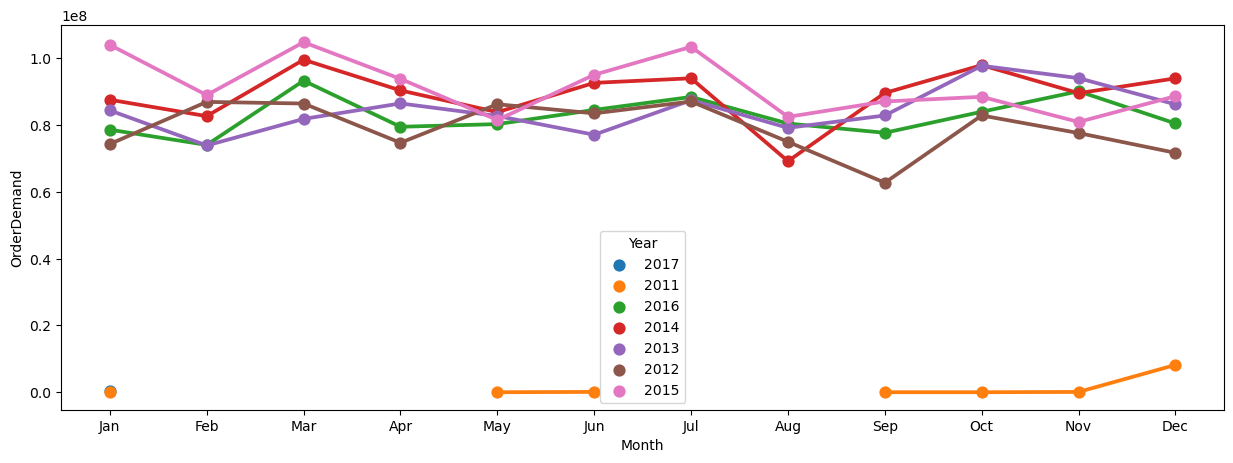

In [41]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[["OrderDemand", 'Month', 'Year']].groupby(["Year",
                                                  "Month"]).sum().reset_index().sort_values(by=['Year', 
                                                                                                 'Month'], ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Month', y="OrderDemand", data=df, hue="Year")
plt.show()

In [42]:
# Statistical information about monthly data
df.describe()

,OrderDemand
count,6.800000e+01
mean,7.550256e+07
std,2.852781e+07
min,2.000000e+00
25%,7.749299e+07
50%,8.369923e+07
75%,8.913704e+07
max,1.048252e+08


#### Warehouse Based Analysis

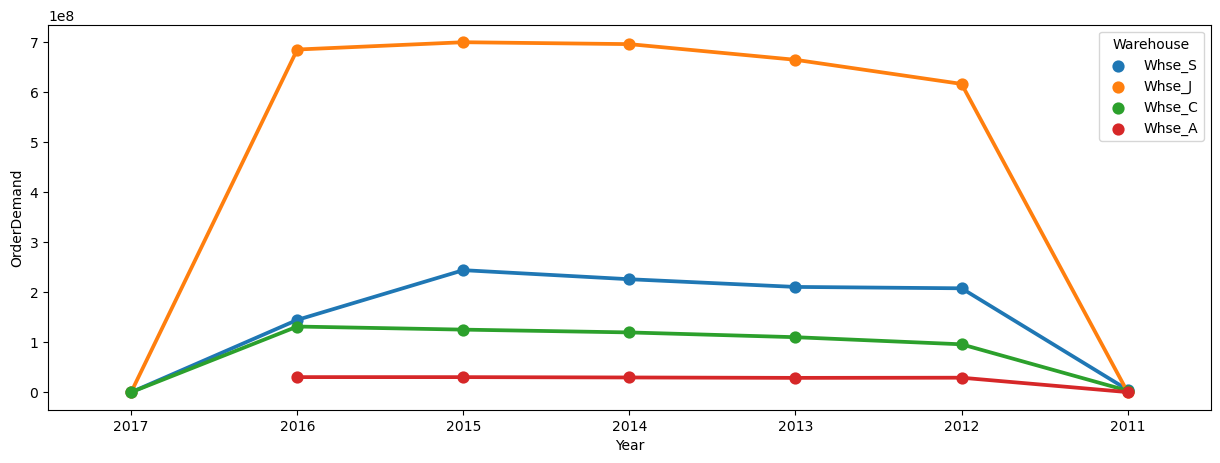

In [43]:
df = data[["OrderDemand", 'Year', 'Warehouse']].groupby(["Year",
                                                         "Warehouse"]).sum().reset_index().sort_values(by=['Warehouse','Year'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y="OrderDemand", data=df, hue="Warehouse")
plt.show()

In [44]:
df = (df.pivot(index='Year', columns='Warehouse', values='OrderDemand'))
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Year,,,,
2011,230881.0,3031847.0,198547.0,4902619.0
2012,29048000.0,95823181.0,616560449.0,207828361.0
2013,28696890.0,110035879.0,664781670.0,210573483.0
2014,29507380.0,119583036.0,696130811.0,225957140.0
2015,30167990.0,125188986.0,699932604.0,244108811.0
2016,30226290.0,131373097.0,685336996.0,144654016.0
2017,NaN,35378.0,259319.0,270.0


In [46]:
df.describe()

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
count,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
mean,2.464624e+07,8.358163e+07,4.804572e+08,1.482892e+08
std,1.197623e+07,5.719735e+07,3.292411e+08,1.042437e+08
min,2.308810e+05,3.537800e+04,1.985470e+05,2.700000e+02
25%,2.878467e+07,4.942751e+07,3.084099e+08,7.477832e+07
50%,2.927769e+07,1.100359e+08,6.647817e+08,2.078284e+08
75%,3.000284e+07,1.223860e+08,6.907339e+08,2.182653e+08
max,3.022629e+07,1.313731e+08,6.999326e+08,2.441088e+08


#### Product Category Based Analysis

In [47]:
df = data[["OrderDemand",
           'ProductCategory', 'Warehouse']].groupby(["ProductCategory",
                                                     "Warehouse"]).sum().reset_index().sort_values(by=['OrderDemand'],
                                                                                                   ascending=False)
df = df.pivot(index='ProductCategory', columns='Warehouse', values='OrderDemand')
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
ProductCategory,,,,
Category_001,1749.0,60106.0,1.623054e+06,72564.0
Category_002,NaN,NaN,NaN,628.0
Category_003,131607.0,NaN,3.926700e+04,222076.0
Category_004,NaN,NaN,NaN,99046.0
Category_005,1124300.0,12528700.0,1.289245e+08,57097050.0
Category_006,11613427.0,33131500.0,3.187667e+08,42059693.0
Category_007,2839680.0,7179524.0,1.121572e+08,6515085.0
Category_008,1903.0,317.0,1.534800e+04,NaN
Category_009,920903.0,251031.0,4.464690e+05,2163738.0


## Forecast the Order Demand with LSTM Model

In [49]:
# data yg digunakan tahun 2012 sampai tahun 2016
df = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df = df.groupby('Date')['OrderDemand'].sum().reset_index()
df

,Date,OrderDemand
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774
...,...,...
1676,2016-12-26,3628370
1677,2016-12-27,1674226
1678,2016-12-28,2740302
1679,2016-12-29,530487


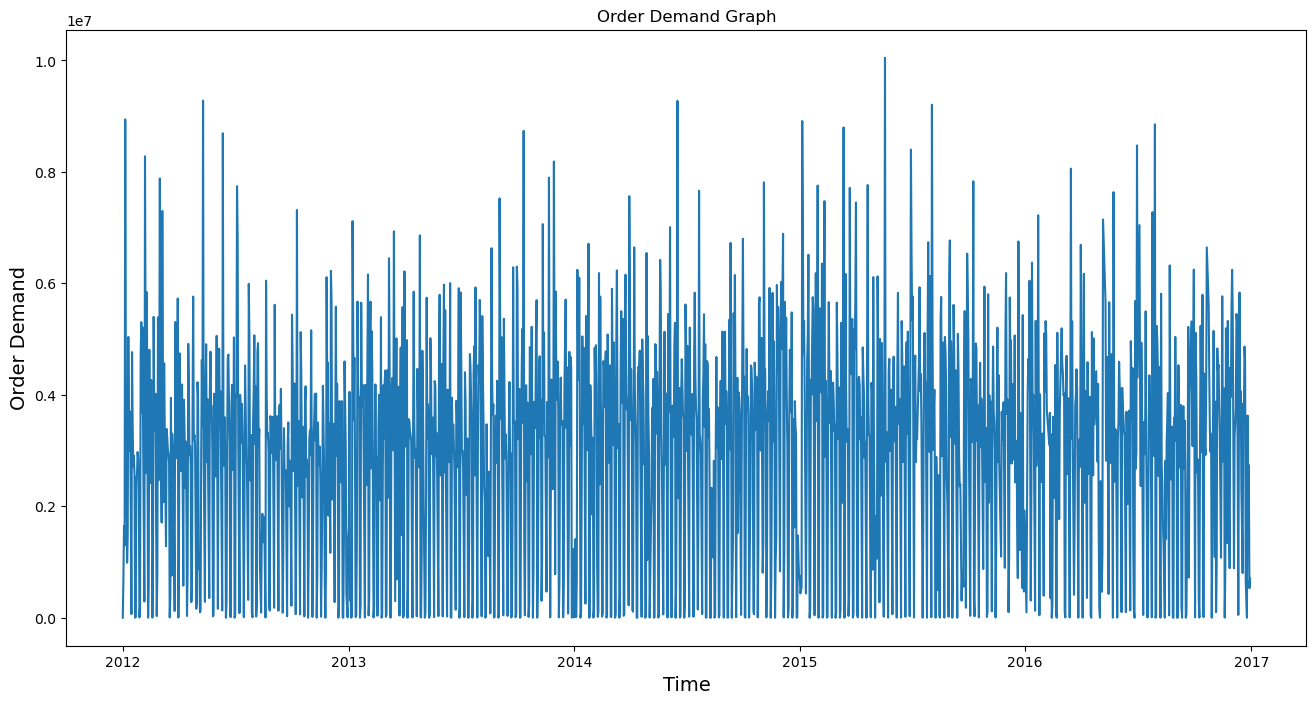

In [50]:
# Grafik order demand
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["OrderDemand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [52]:
# Membuat data baru dengan hanya kolom OrderDemand
orderD = df.filter(["OrderDemand"])
# Convert the dataframe to a np array
orderD_array = orderD.values

train_close_len = math.ceil(len(orderD_array) * 0.8)
train_close_len

1345

In [53]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(orderD_array)
scaled_data

array([[1.99031453e-07],
       [6.76982600e-02],
       [1.63728946e-01],
       ...,
       [2.72703145e-01],
       [5.27917993e-02],
       [6.99545800e-02]])

In [54]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([1.99031453e-07, 6.76982600e-02, 1.63728946e-01, 1.28958549e-01,
       8.89847137e-01, 4.36947184e-01, 9.82368500e-02, 1.43570443e-01,
       5.01388891e-01, 3.30568853e-01, 2.98325061e-01, 3.68113549e-01,
       6.39388544e-03, 4.74326585e-01, 3.44696702e-01, 2.69870529e-01,
       2.89035666e-01, 2.55127374e-01, 1.99031453e-05, 1.34953277e-03,
       2.51593073e-01, 2.53474816e-01, 2.95791390e-01, 2.81800375e-01,
       2.26411613e-01, 6.16997505e-04, 2.32949398e-02, 4.68048834e-01,
       5.27871021e-01, 3.66383269e-01, 5.18157490e-01, 3.13818067e-01,
       2.88706070e-02, 8.24073013e-01, 4.73426465e-01, 2.58256546e-01,
       5.81354156e-01, 3.14602052e-01, 9.95157266e-05, 5.74927232e-02,
       4.78518585e-01, 2.40411486e-01, 3.48965828e-01, 4.24549316e-01,
       2.88825090e-01, 1.69176735e-04, 1.26577138e-01, 5.37255155e-01,
       3.60979068e-01, 3.33127004e-01, 3.99856478e-01, 1.72541561e-01,
       2.98547180e-03, 8.14840741e-02, 5.36301397e-01, 2.45390755e-01,
     

In [55]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [56]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1285, 60, 1)

In [57]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = df.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [58]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build a LSTM Model

In [59]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

2024-03-07 20:14:14.501906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [60]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [61]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
13/13 [==============================] - 27s 2s/step - loss: 0.0560 - mae: 0.1944
Epoch 2/3
13/13 [==============================] - 22s 2s/step - loss: 0.0426 - mae: 0.1662
Epoch 3/3
13/13 [==============================] - 20s 2s/step - loss: 0.0409 - mae: 0.1632


In [62]:
# predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 4s 297ms/step


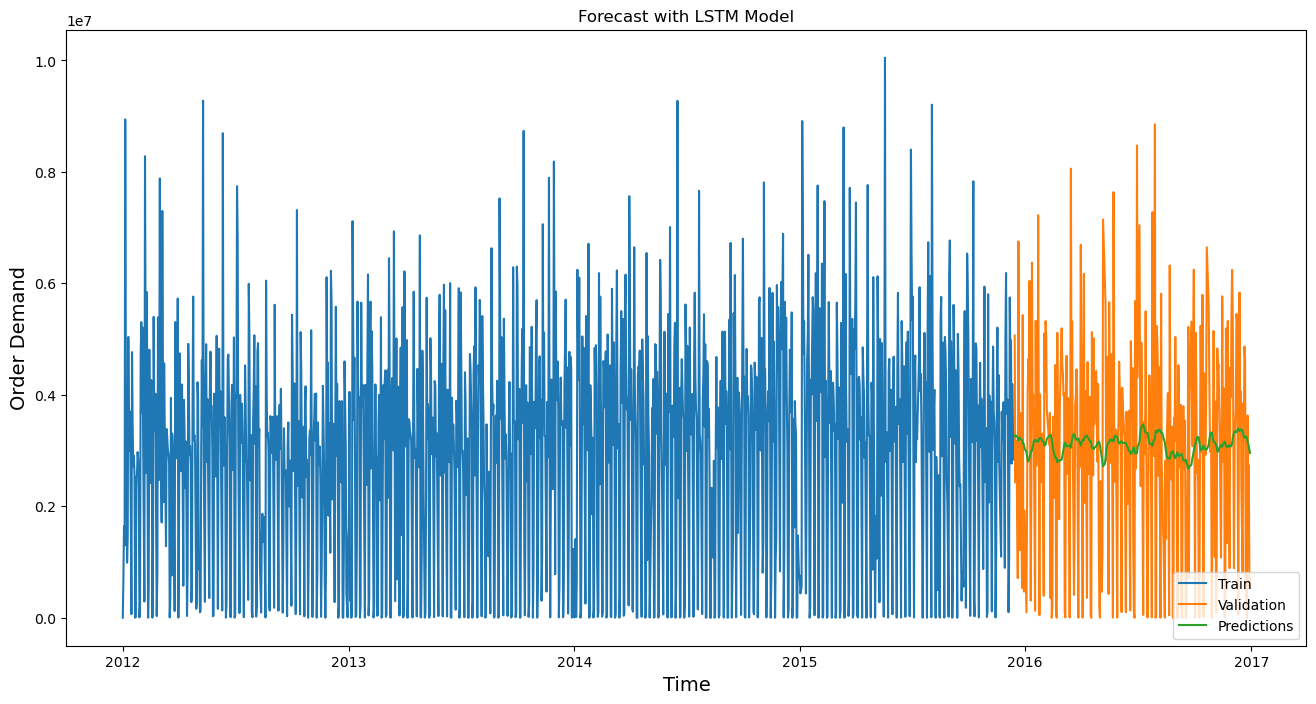

In [63]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

## Build an Optimized LSTM Model

In [64]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(256, activation='relu', return_sequences=False))

optimized_model.add(Dense(128))

optimized_model.add(Dense(64))

optimized_model.add(Dense(32))

optimized_model.add(Dense(1))

In [66]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [67]:
# train the optimized model
optimized_model.fit(X_train, y_train, 
          batch_size=32, 
          epochs=20, 
          verbose=1)

Epoch 1/20
41/41 [==============================] - 43s 927ms/step - loss: 0.0450 - mae: 0.1719
Epoch 2/20
41/41 [==============================] - 36s 866ms/step - loss: 0.0406 - mae: 0.1626
Epoch 3/20
41/41 [==============================] - 40s 973ms/step - loss: 0.0404 - mae: 0.1627
Epoch 4/20
41/41 [==============================] - 37s 893ms/step - loss: 0.0405 - mae: 0.1631
Epoch 5/20
41/41 [==============================] - 42s 1s/step - loss: 0.0393 - mae: 0.1600
Epoch 6/20
41/41 [==============================] - 45s 1s/step - loss: 0.0402 - mae: 0.1626
Epoch 7/20
41/41 [==============================] - 51s 1s/step - loss: 0.0376 - mae: 0.1573
Epoch 8/20
41/41 [==============================] - 41s 996ms/step - loss: 0.0357 - mae: 0.1528
Epoch 9/20
41/41 [==============================] - 43s 1s/step - loss: 0.0359 - mae: 0.1542
Epoch 10/20
41/41 [==============================] - 41s 1s/step - loss: 0.0345 - mae: 0.1494
Epoch 11/20
41/41 [==============================] - 4

In [68]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

11/11 [==============================] - 5s 260ms/step


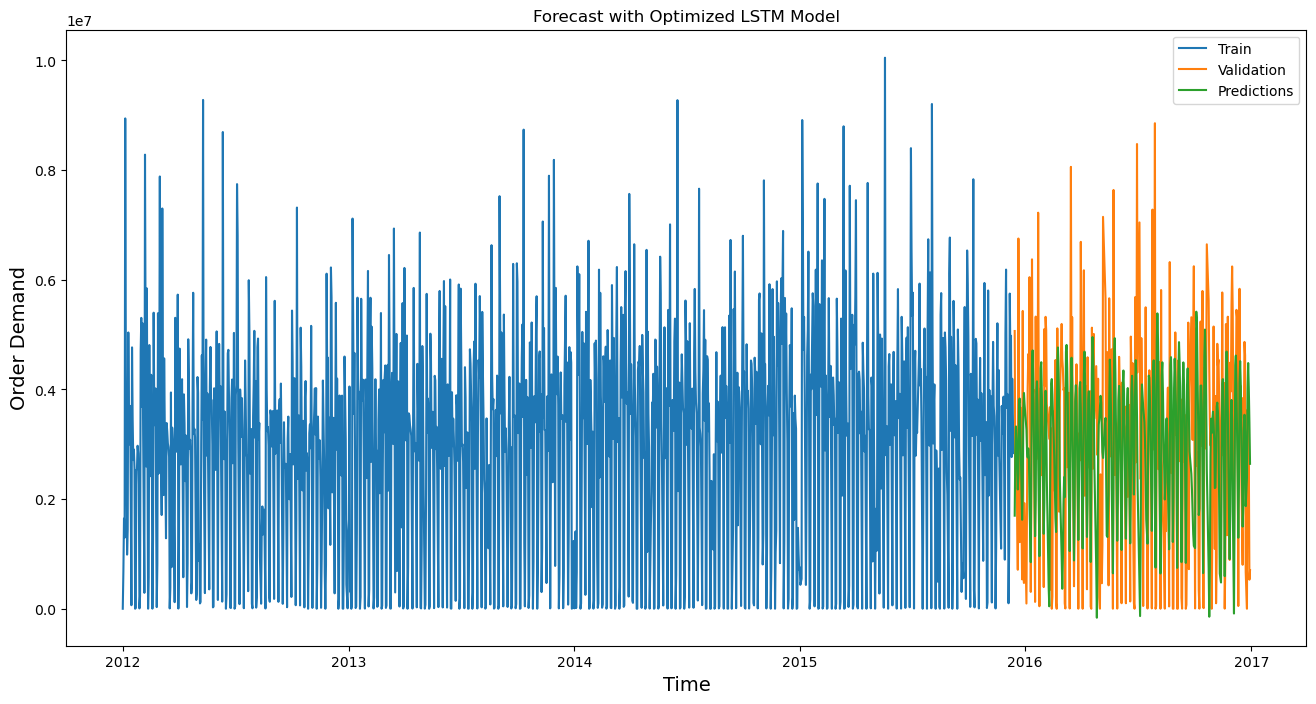

In [69]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="upper right")
plt.show()